In [1]:
!wget https://github.com/WiraDKP/unsupervised_learning/raw/master/19%20-%20Deep%20Unsupervised%20Learning/01%20-%20Autoencoder/data.zip

--2023-11-07 09:03:05--  https://github.com/WiraDKP/unsupervised_learning/raw/master/19%20-%20Deep%20Unsupervised%20Learning/01%20-%20Autoencoder/data.zip
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/WiraDKP/unsupervised_learning/master/19%20-%20Deep%20Unsupervised%20Learning/01%20-%20Autoencoder/data.zip [following]
--2023-11-07 09:03:05--  https://raw.githubusercontent.com/WiraDKP/unsupervised_learning/master/19%20-%20Deep%20Unsupervised%20Learning/01%20-%20Autoencoder/data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 882973 (862K) [application/zip]
Saving to: ‘data.zip’

data.zip   

In [3]:
!unzip data.zip

In [5]:
!pip install jcopdl==1.1.1

In [6]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

dataset & dataloader

In [4]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [8]:
bs = 64

transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor()
])

train_set = datasets.ImageFolder("/content/data/train", transform=transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True, num_workers=4)

test_set = datasets.ImageFolder("/content/data/test", transform=transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True)

Arsitektur & Config

In [9]:
from jcopdl.layers import linear_block

#z_size -> size of latent space

class AutoEncoder(nn.Module):
    def __init__(self, z_size):
        super().__init__()
        self.encode = nn.Sequential(
            linear_block(784, 512, batch_norm=True),
            linear_block(512, 256, batch_norm=True),
            linear_block(256, z_size, activation='sigmoid')
        )

        self.decode = nn.Sequential(
            linear_block(z_size, 256, batch_norm=True),
            linear_block(256, 512, batch_norm=True),
            linear_block(512, 784, activation='sigmoid')
        )

    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x


In [10]:
config = set_config({
    "z_size" : 32,
    "batch_size" : bs,
})

training preparation -> MCOC

In [11]:
model = AutoEncoder(config.z_size).to(device)
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir="ae")

training

In [15]:
 from tqdm.auto import tqdm

 def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()

    cost = 0
    for feature, _ in tqdm(dataloader, desc=mode.title()):
        feature = feature.view(-1, 784).to(device)

        output = model(feature)
        loss = criterion(output, feature) # karena kita tidak butuh label, kita bandingin output dengan input

        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        cost += loss.item() * feature.shape[0]
    cost = cost / len(dataset)
    return cost

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e30e4f59480>
Traceback (most recent call last):


Train:   0%|          | 0/25 [00:20<?, ?it/s]

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 0.3358 | Test_cost  = 0.2613 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 0.1836 | Test_cost  = 0.1731 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 0.1590 | Test_cost  = 0.1515 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 0.1450 | Test_cost  = 0.1405 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 0.1357 | Test_cost  = 0.1333 | 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e30e4f59480>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e30e4f59480>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Train:   0%|          | 0/25 [00:00<?, ?it/s]

: can only test a child process


Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 0.1284 | Test_cost  = 0.1274 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 0.1223 | Test_cost  = 0.1234 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 0.1178 | Test_cost  = 0.1203 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     9
Train_cost  = 0.1143 | Test_cost  = 0.1182 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    10
Train_cost  = 0.1105 | Test_cost  = 0.1148 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    11
Train_cost  = 0.1077 | Test_cost  = 0.1127 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e30e4f59480>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e30e4f59480>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    12
Train_cost  = 0.1050 | Test_cost  = 0.1109 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    13
Train_cost  = 0.1026 | Test_cost  = 0.1098 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    14
Train_cost  = 0.1002 | Test_cost  = 0.1088 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    15
Train_cost  = 0.0990 | Test_cost  = 0.1082 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    16
Train_cost  = 0.0978 | Test_cost  = 0.1071 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    17
Train_cost  = 0.0961 | Test_cost  = 0.1051 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    18
Train_cost  = 0.0947 | Test_cost  = 0.1046 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    19
Train_cost  = 0.0936 | Test_cost  = 0.1040 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    20
Train_cost  = 0.0922 | Test_cost  = 0.1038 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    21
Train_cost  = 0.0909 | Test_cost  = 0.1030 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    22
Train_cost  = 0.0910 | Test_cost  = 0.1024 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    23
Train_cost  = 0.0899 | Test_cost  = 0.1019 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    24
Train_cost  = 0.0895 | Test_cost  = 0.1027 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1019


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    25
Train_cost  = 0.0884 | Test_cost  = 0.1013 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    26
Train_cost  = 0.0880 | Test_cost  = 0.1011 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    27
Train_cost  = 0.0863 | Test_cost  = 0.1004 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    28
Train_cost  = 0.0863 | Test_cost  = 0.1005 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1004


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    29
Train_cost  = 0.0862 | Test_cost  = 0.1007 | 
==> EarlyStop patience =  2 | Best test_cost: 0.1004


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    30
Train_cost  = 0.0852 | Test_cost  = 0.1001 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    31
Train_cost  = 0.0844 | Test_cost  = 0.0992 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    32
Train_cost  = 0.0841 | Test_cost  = 0.1001 | 
==> EarlyStop patience =  1 | Best test_cost: 0.0992


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    33
Train_cost  = 0.0834 | Test_cost  = 0.0991 | 


Train:   0%|          | 0/25 [02:20<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e30e4f59480>
Traceback (most recent call last):
Exception ignored in:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7e30e4f59480>    self._shutdown_workers()

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
        if w.is_alive():self._shutdown_workers()

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
      File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    if w.is_alive():assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/usr/lib/python3.10/multiprocessing/process.py", line 1

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    34
Train_cost  = 0.0828 | Test_cost  = 0.0994 | 
==> EarlyStop patience =  1 | Best test_cost: 0.0991


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    35
Train_cost  = 0.0834 | Test_cost  = 0.1004 | 
==> EarlyStop patience =  2 | Best test_cost: 0.0991


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    36
Train_cost  = 0.0833 | Test_cost  = 0.0987 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    37
Train_cost  = 0.0821 | Test_cost  = 0.0990 | 
==> EarlyStop patience =  1 | Best test_cost: 0.0987


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    38
Train_cost  = 0.0813 | Test_cost  = 0.0984 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    39
Train_cost  = 0.0808 | Test_cost  = 0.0985 | 
==> EarlyStop patience =  1 | Best test_cost: 0.0984


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    40
Train_cost  = 0.0807 | Test_cost  = 0.0986 | 
==> EarlyStop patience =  2 | Best test_cost: 0.0984


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    41
Train_cost  = 0.0806 | Test_cost  = 0.0988 | 
==> EarlyStop patience =  3 | Best test_cost: 0.0984


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    42
Train_cost  = 0.0804 | Test_cost  = 0.0982 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    43
Train_cost  = 0.0801 | Test_cost  = 0.0984 | 
==> EarlyStop patience =  1 | Best test_cost: 0.0982


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    44
Train_cost  = 0.0798 | Test_cost  = 0.0991 | 
==> EarlyStop patience =  2 | Best test_cost: 0.0982


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    45
Train_cost  = 0.0792 | Test_cost  = 0.0979 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    46
Train_cost  = 0.0786 | Test_cost  = 0.0979 | 
==> EarlyStop patience =  1 | Best test_cost: 0.0979


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    47
Train_cost  = 0.0786 | Test_cost  = 0.0982 | 
==> EarlyStop patience =  2 | Best test_cost: 0.0979


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    48
Train_cost  = 0.0783 | Test_cost  = 0.0980 | 
==> EarlyStop patience =  3 | Best test_cost: 0.0979


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    49
Train_cost  = 0.0785 | Test_cost  = 0.0982 | 
==> EarlyStop patience =  4 | Best test_cost: 0.0979


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    50
Train_cost  = 0.0782 | Test_cost  = 0.0983 | 
==> EarlyStop patience =  5 | Best test_cost: 0.0979
==> Execute Early Stopping at epoch: 50 | Best test_cost: 0.0979
==> Best model is saved at ae


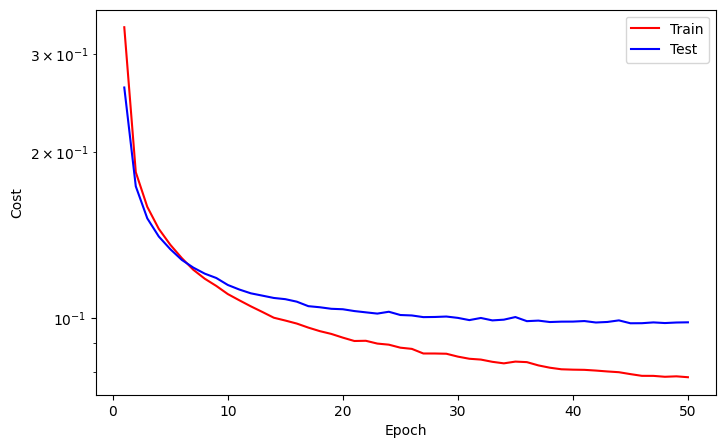

In [16]:
while True:
    train_cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)

    #logging
    callback.log(train_cost, test_cost)

    #checkpoint
    callback.save_checkpoint()

    #early stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

evaluate

In [17]:
feature, target = next(iter(testloader))
feature = feature.view(-1, 784).to(device)

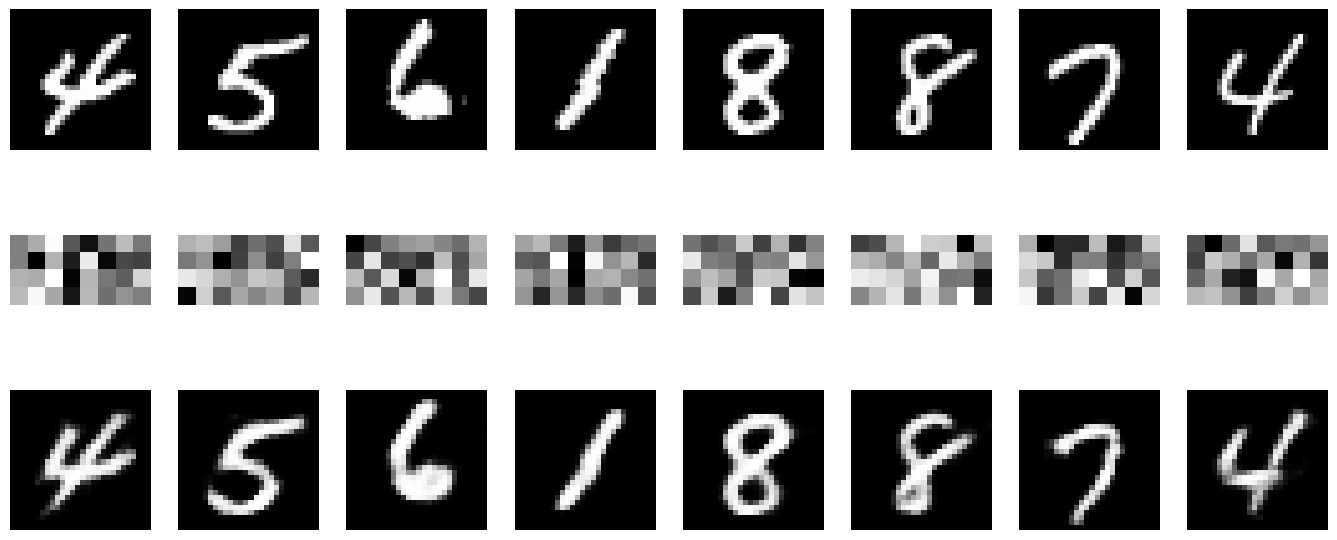

In [19]:
with torch.no_grad():
    model.eval()
    enc = model.encode(feature)
    dec = model.decode(enc)

fig, ax = plt.subplots(3, 8, figsize=(17, 7))
for i in range(8):
    ax[0, i].imshow(feature[i].view(28, 28).cpu(), cmap='gray')
    ax[0, i].axis('off')

    ax[1, i].imshow(enc[i].view(4, 8).cpu(), cmap='gray')
    ax[1, i].axis('off')

    ax[2, i].imshow(dec[i].view(28, 28).cpu(), cmap='gray')
    ax[2, i].axis('off')


playground

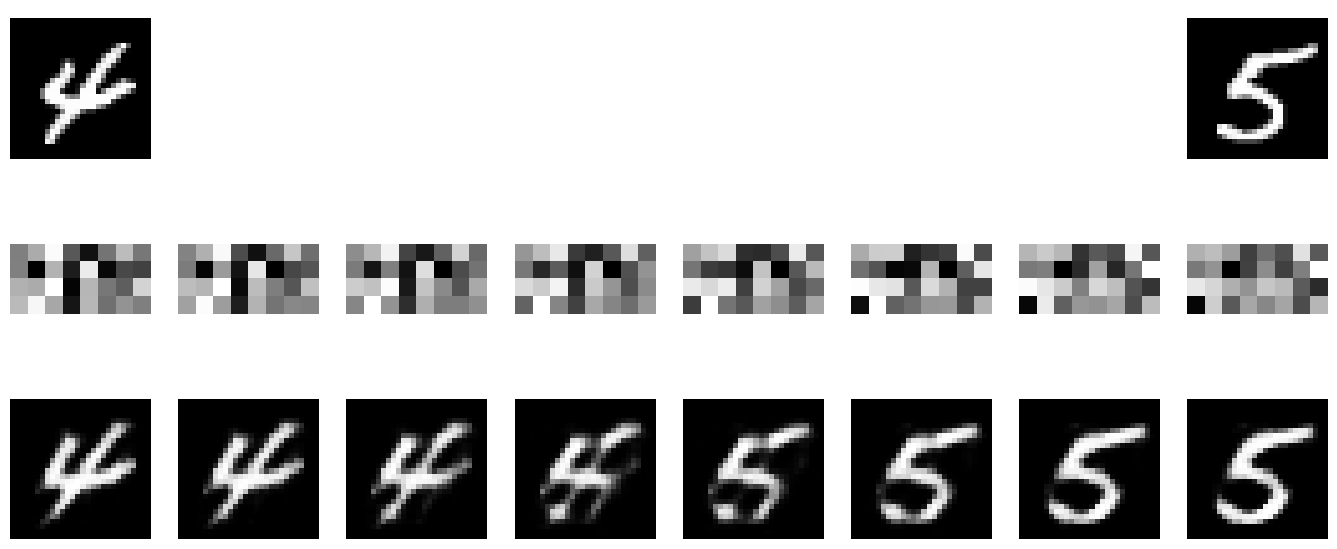

In [20]:
with torch.no_grad():
    model.eval()
    enc = model.encode(feature)

    code1, code2 = enc[0], enc[1]
    codes = [(1-i) * code1 + i*code2 for i in np.linspace(0, 1, 8)]
    enc = torch.stack(codes)

    dec = model.decode(enc)


fig, ax = plt.subplots(3, 8, figsize=(17, 7))

ax[0, 0].imshow(feature[0].view(28, 28).cpu(), cmap='gray')
ax[0, 7].imshow(feature[1].view(28, 28).cpu(), cmap='gray')

for i in range(8):
    ax[0, i].axis('off')

    ax[1, i].imshow(enc[i].view(4, 8).cpu(), cmap='gray')
    ax[1, i].axis('off')

    ax[2, i].imshow(dec[i].view(28, 28).cpu(), cmap='gray')
    ax[2, i].axis('off')


Denoising AutoEncoder

In [26]:
def add_noise(images, noise_factor=0.5):
    images = torch.clone(images)
    images += noise_factor * torch.rand_like(images)
    # batasi hasil perkalian lebih dari 1
    images = images.clamp(0., 1.)
    return images

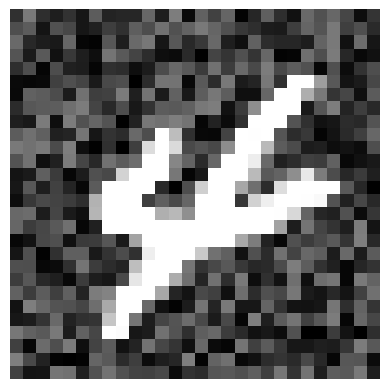

In [28]:
plt.imshow(add_noise(feature[0]).view(28, 28).cpu(), cmap='gray')
plt.axis('off');

training preparation

In [30]:
model = AutoEncoder(config.z_size).to(device)
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir="dae")

training

input ditambah noise, target tetap bersih

In [31]:
 from tqdm.auto import tqdm

 def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()

    cost = 0
    for feature, _ in tqdm(dataloader, desc=mode.title()):
        feature = feature.view(-1, 784).to(device)

        output = model(add_noise(feature))
        loss = criterion(output, feature) # karena kita tidak butuh label, kita bandingin output dengan input

        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        cost += loss.item() * feature.shape[0]
    cost = cost / len(dataset)
    return cost

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 0.3390 | Test_cost  = 0.2631 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 0.1867 | Test_cost  = 0.1770 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 0.1625 | Test_cost  = 0.1564 | 


Train:   0%|          | 0/25 [01:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 0.1498 | Test_cost  = 0.1471 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 0.1404 | Test_cost  = 0.1383 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 0.1327 | Test_cost  = 0.1329 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 0.1277 | Test_cost  = 0.1287 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 0.1238 | Test_cost  = 0.1261 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     9
Train_cost  = 0.1195 | Test_cost  = 0.1249 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    10
Train_cost  = 0.1165 | Test_cost  = 0.1201 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    11
Train_cost  = 0.1137 | Test_cost  = 0.1179 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    12
Train_cost  = 0.1112 | Test_cost  = 0.1168 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    13
Train_cost  = 0.1089 | Test_cost  = 0.1169 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1168


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    14
Train_cost  = 0.1070 | Test_cost  = 0.1141 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    15
Train_cost  = 0.1053 | Test_cost  = 0.1137 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    16
Train_cost  = 0.1038 | Test_cost  = 0.1129 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    17
Train_cost  = 0.1021 | Test_cost  = 0.1116 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    18
Train_cost  = 0.1007 | Test_cost  = 0.1108 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    19
Train_cost  = 0.1000 | Test_cost  = 0.1096 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    20
Train_cost  = 0.0985 | Test_cost  = 0.1086 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    21
Train_cost  = 0.0980 | Test_cost  = 0.1086 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1086


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    22
Train_cost  = 0.0967 | Test_cost  = 0.1085 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    23
Train_cost  = 0.0965 | Test_cost  = 0.1082 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    24
Train_cost  = 0.0954 | Test_cost  = 0.1065 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    25
Train_cost  = 0.0940 | Test_cost  = 0.1068 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1065


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    26
Train_cost  = 0.0941 | Test_cost  = 0.1074 | 
==> EarlyStop patience =  2 | Best test_cost: 0.1065


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    27
Train_cost  = 0.0931 | Test_cost  = 0.1061 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    28
Train_cost  = 0.0925 | Test_cost  = 0.1065 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1061


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    29
Train_cost  = 0.0922 | Test_cost  = 0.1060 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    30
Train_cost  = 0.0916 | Test_cost  = 0.1049 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    31
Train_cost  = 0.0909 | Test_cost  = 0.1053 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1049


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    32
Train_cost  = 0.0908 | Test_cost  = 0.1052 | 
==> EarlyStop patience =  2 | Best test_cost: 0.1049


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    33
Train_cost  = 0.0895 | Test_cost  = 0.1041 | 


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    34
Train_cost  = 0.0893 | Test_cost  = 0.1045 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1041


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    35
Train_cost  = 0.0889 | Test_cost  = 0.1043 | 
==> EarlyStop patience =  2 | Best test_cost: 0.1041


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    36
Train_cost  = 0.0884 | Test_cost  = 0.1044 | 
==> EarlyStop patience =  3 | Best test_cost: 0.1041


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    37
Train_cost  = 0.0883 | Test_cost  = 0.1045 | 
==> EarlyStop patience =  4 | Best test_cost: 0.1041


Train:   0%|          | 0/25 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    38
Train_cost  = 0.0876 | Test_cost  = 0.1046 | 
==> EarlyStop patience =  5 | Best test_cost: 0.1041
==> Execute Early Stopping at epoch: 38 | Best test_cost: 0.1041
==> Best model is saved at dae


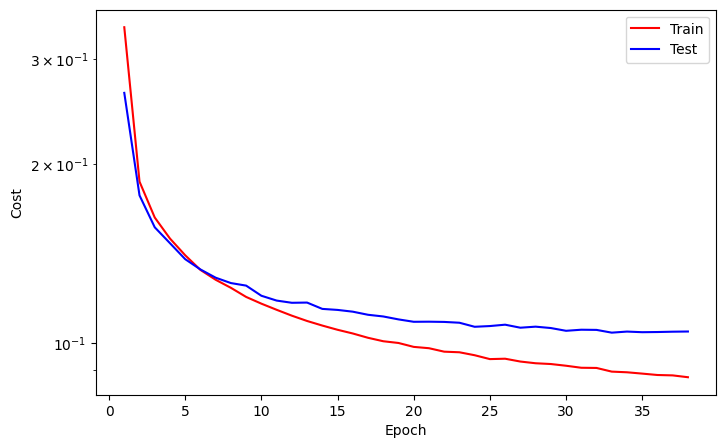

In [32]:
while True:
    train_cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)

    #logging
    callback.log(train_cost, test_cost)

    #checkpoint
    callback.save_checkpoint()

    #early stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

evaluate

In [33]:
feature, target = next(iter(testloader))
feature = add_noise(feature).view(-1, 784).to(device)

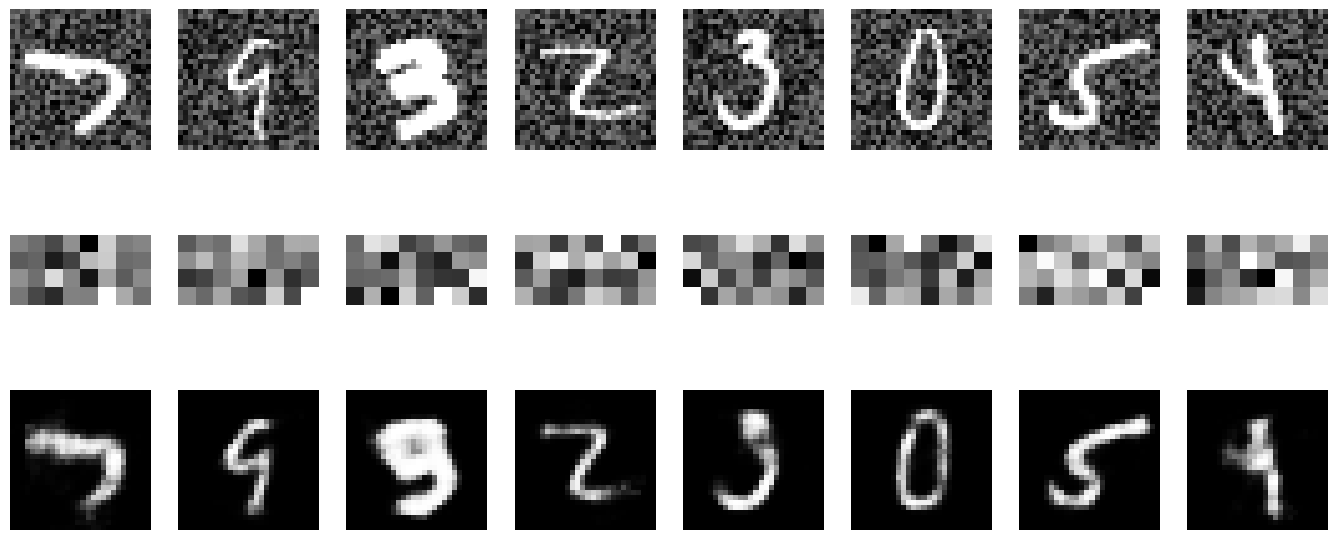

In [34]:
with torch.no_grad():
    model.eval()
    enc = model.encode(feature)
    dec = model.decode(enc)

fig, ax = plt.subplots(3, 8, figsize=(17, 7))
for i in range(8):
    ax[0, i].imshow(feature[i].view(28, 28).cpu(), cmap='gray')
    ax[0, i].axis('off')

    ax[1, i].imshow(enc[i].view(4, 8).cpu(), cmap='gray')
    ax[1, i].axis('off')

    ax[2, i].imshow(dec[i].view(28, 28).cpu(), cmap='gray')
    ax[2, i].axis('off')
